In [3]:
import os
import glob
import pandas as pd

from pybaseball import cache, pitching_stats_bref, playerid_reverse_lookup, get_splits

cache.enable()

In [8]:
# Create the 'data' directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Loop through years from 2008 to 2022
for year in range(2008, 2023):
    file_path = f'data/data-{year}-pitching-bref.csv'  # specify the directory and filename

    # Check if the file already exists
    if os.path.exists(file_path):
        continue

    data_pitching_bref = pitching_stats_bref(year)
    data_pitching_bref.to_csv(file_path, index=False)


### 註：以上這段下載資料的時候，約費時 11 分鐘。

In [9]:
# 確認每個 data 中的 csv 檔案都有相同的欄位

reference_columns = None

# Loop through years from 2008 to 2022
for year in range(2008, 2023):
    file_path = f'data/data-{year}-pitching-bref.csv'
    data_pitching_bref = pd.read_csv(file_path)
    
    # Set the reference columns if not set
    if reference_columns is None:
        reference_columns = data_pitching_bref.columns
        print(f"Reference columns for year {year}:")
        print(reference_columns)
    else:
        # Check if the columns are the same as the reference columns
        if data_pitching_bref.columns.equals(reference_columns):
            print(f"Columns for year {year} match the reference columns.")
        else:
            print(f"Columns for year {year} do NOT match the reference columns:")
            print(data_pitching_bref.columns)



Reference columns for year 2008:
Index(['Name', 'Age', '#days', 'Lev', 'Tm', 'G', 'GS', 'W', 'L', 'SV', 'IP',
       'H', 'R', 'ER', 'BB', 'SO', 'HR', 'HBP', 'ERA', 'AB', '2B', '3B', 'IBB',
       'GDP', 'SF', 'SB', 'CS', 'PO', 'BF', 'Pit', 'Str', 'StL', 'StS',
       'GB/FB', 'LD', 'PU', 'WHIP', 'BAbip', 'SO9', 'SO/W', 'mlbID'],
      dtype='object')
Columns for year 2009 match the reference columns.
Columns for year 2010 match the reference columns.
Columns for year 2011 match the reference columns.
Columns for year 2012 match the reference columns.
Columns for year 2013 match the reference columns.
Columns for year 2014 match the reference columns.
Columns for year 2015 match the reference columns.
Columns for year 2016 match the reference columns.
Columns for year 2017 match the reference columns.
Columns for year 2018 match the reference columns.
Columns for year 2019 match the reference columns.
Columns for year 2020 match the reference columns.
Columns for year 2021 match the re

In [10]:

files = glob.glob('data/data-*-pitching-bref.csv')

# Create an empty list to hold DataFrames
dfs = []

# Loop through each file and read it into a DataFrame
for file in files:
    # Extract the year from the file name
    year = int(file.split('-')[1])

    # Read the CSV file into a DataFrame and add a 'year' column
    df = pd.read_csv(file)
    df['year'] = year

    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
pitching_stats_all = pd.concat(dfs)
print(f"Number of rows in pitching_stats_all: {len(pitching_stats_all)}")


Number of rows in pitching_stats_all: 11022


In [11]:
pitching_stats_all.head()

,Name,Age,#days,Lev,Tm,G,GS,W,L,SV,...,StS,GB/FB,LD,PU,WHIP,BAbip,SO9,SO/W,mlbID,year
0,Fernando Abad,33,1310,Maj-NL,San Francisco,21,0,NaN,2.0,NaN,...,0.11,0.62,0.19,0.03,0.923,0.200,6.2,3.00,472551,2019
1,Bryan Abreu,22,1309,Maj-AL,Houston,7,0,NaN,NaN,NaN,...,0.19,0.50,0.31,0.00,0.808,0.250,13.5,4.33,650556,2019
2,Jason Adam,27,1309,Maj-AL,Toronto,23,0,3.0,NaN,NaN,...,0.11,0.29,0.24,0.18,1.154,0.237,7.5,1.80,592094,2019
3,Austin Adams,32,1394,Maj-AL,"Detroit,Minnesota",15,0,NaN,NaN,NaN,...,0.11,0.42,0.21,0.09,1.860,0.286,7.6,1.08,542866,2019
4,Austin Adams,28,1317,"Maj-AL,Maj-NL","Seattle,Washington",30,2,2.0,2.0,NaN,...,0.16,0.50,0.18,0.05,1.125,0.286,14.9,3.31,613534,2019


In [12]:
# 去除掉沒有救援記錄的投手
# drop those rows with missing values in `SV`, save to a new DataFrame
pitching_stats_all_only_saves = pitching_stats_all.dropna(subset=['SV'])

# print the number of rows in the new DataFrame
print(f"Number of rows: {len(pitching_stats_all_only_saves)}")


Number of rows: 2288


In [13]:
pitching_stats_all_only_saves[['SV', 'G', 'IP', 'GS']].describe()


,SV,G,IP,GS
count,2288.00000,2288.000000,2288.000000,2288.000000
mean,7.70979,49.115822,54.291740,1.279720
std,11.40753,20.420956,25.557407,4.327689
min,1.00000,1.000000,0.100000,0.000000
25%,1.00000,32.000000,37.200000,0.000000
50%,2.00000,55.000000,57.100000,0.000000
75%,8.00000,66.000000,67.400000,0.000000
max,62.00000,86.000000,204.200000,33.000000


### 對於終結者的假設


In [14]:
# GS: 先發場次要小於平均數
# IP: 投球局數要超過平均數
# SV: 救援成功要超過平均數
pitching_stats_all_only_saves_potential_closers = pitching_stats_all_only_saves[
    (pitching_stats_all_only_saves['GS'] < pitching_stats_all_only_saves['GS'].mean()) &
    (pitching_stats_all_only_saves['IP'] > pitching_stats_all_only_saves['IP'].mean()) & 
    (pitching_stats_all_only_saves['SV'] > pitching_stats_all_only_saves['SV'].mean())
]

# print the number of rows in the new DataFrame
print(f"Number of rows: {len(pitching_stats_all_only_saves_potential_closers)}")

Number of rows: 441


In [15]:
pitching_stats_all_only_saves_potential_closers.head()


,Name,Age,#days,Lev,Tm,G,GS,W,L,SV,...,StS,GB/FB,LD,PU,WHIP,BAbip,SO9,SO/W,mlbID,year
92,Archie Bradley,26,1311,Maj-NL,Arizona,66,1,4.0,5.0,18.0,...,0.10,0.47,0.31,0.06,1.437,0.341,10.9,2.42,605151,2019
133,Aroldis Chapman,31,1309,Maj-AL,New York,60,0,3.0,2.0,37.0,...,0.14,0.43,0.30,0.06,1.105,0.292,13.4,3.40,547973,2019
153,Alex Colom\xc3\xa9,30,1310,Maj-AL,Chicago,62,0,4.0,5.0,30.0,...,0.13,0.44,0.28,0.03,1.066,0.217,8.1,2.39,517008,2019
184,Edwin D\xc3\xadaz,25,1310,Maj-NL,New York,66,0,2.0,7.0,26.0,...,0.18,0.36,0.28,0.06,1.379,0.381,15.4,4.50,621242,2019
193,Sean Doolittle,32,1310,Maj-NL,Washington,63,0,6.0,5.0,29.0,...,0.12,0.25,0.24,0.14,1.300,0.315,9.9,4.40,448281,2019


In [16]:
# average count of players from 2008 to 2022
average_closers_per_season = len(
    pitching_stats_all_only_saves_potential_closers) / (2022 - 2008 + 1)

average_closers_per_season

29.4

### 大致上符合每一隊都有一個終結者的數字，先前的假設成立

但其實後來發現，沒有 2020 的數據，因為疫情的關係？

In [64]:
# average count of players from 2008 to 2022, excluding 2020
adjusted_average_closers_per_season = len(
    pitching_stats_all_only_saves_potential_closers) / (2022 - 2008 + 1 - 1)

adjusted_average_closers_per_season

31.5

仍是大概符合每一隊有一個終結者，`但這個數字比較合理`：
1. 可能因為受傷等原因會有兩個人先後被派任為終結者
2. 不可能每次那麼剛好救援情況，終結者都有辦法上場，例如前一天可能投了超過設定用球數的球

## 取得「被推派為終結者」年份，非救援情況下的資料

這邊的「推派」有點為妙，因為有時候總教練並不會明確指定。

例如 2019 年底的 Archie Bradley，可以參考[這篇新聞](
https://www.forbes.com/sites/jackmagruder/2019/08/09/archie-bradley-steps-into-the-closers-role-in-arizona/?sh=34436d585449
)：

> Manager Torey Lovullo has not specifically named Bradley as his closer, but he does not need to. The proof is in the usage. 

然而，就表現來看，他確實是那一年的終結者。


所以這邊會以上面 `pitching_stats_all_only_saves_potential_closers` 作為基礎，進行每一個年度的 game splits 取得資料，再彙整分析。



In [24]:
# 取得每一個終結者該球季的 splits

# 假設您已經有了一個名為 pitching_stats_all_only_saves_potential_closers 的 DataFrame
# 取得 mlbID 列表
player_ids = pitching_stats_all_only_saves_potential_closers['mlbID'].tolist()

# 使用 player_ids 執行 playerid_reverse_lookup
players_info = playerid_reverse_lookup(player_ids, key_type='mlbam')

id_to_bbref = dict(zip(players_info['key_mlbam'], players_info['key_bbref']))

# 建立目錄存放 CSV 文件
output_folder = "./data/pitching_splits_closer_2008_2022"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
for index, row in pitching_stats_all_only_saves_potential_closers.iterrows():
    mlb_id = row['mlbID']
    year = row['year']
    name = row['Name']

    key_bbref = id_to_bbref[mlb_id]

    file_name = f"{name}_{year}_pitching_splits.csv"
    file_path = os.path.join(output_folder, file_name)

    if os.path.exists(file_path):
        continue

    splits = get_splits(playerid=key_bbref, year=year, pitching_splits=True)

    # 檢查 splits 是否為 tuple，如果是，則將第一個元素 (DataFrame) 賦值給 splits
    if isinstance(splits, tuple):
        splits = splits[0]

    splits.to_csv(file_path)



### 註：以上這段下載資料的時候，約費時 45 分鐘。

## 接下來的計畫  

將 441 名救援投手的 `in Sv Situ` 與 `in non-Sv` 平均比較


In [4]:
# 以 Minter 2018 舉例
minter_2018 = pd.read_csv('data/pitching_splits_closer_2008_2022/A.J. Minter_2018_pitching_splits.csv')

save_situation_condition = minter_2018['Split'] == 'in Sv Situ'
non_save_situation_condition = minter_2018['Split'] == 'in non-Sv'

save_outcome_rows = minter_2018[save_situation_condition]
non_save_outcome_rows = minter_2018[non_save_situation_condition]

save_outcome_rows


,Split Type,Split,G,PA,AB,R,H,2B,3B,HR,...,GDP,HBP,SH,SF,IBB,ROE,BAbip,tOPS+,sOPS+,1B
19,Game Outcome for Pitcher,in Sv Situ,29,117.0,105,9.0,24,5,1,1,...,0.0,2.0,0,1,0,1,0.329,94,88.0,17


In [5]:
non_save_outcome_rows

,Split Type,Split,G,PA,AB,R,H,2B,3B,HR,...,GDP,HBP,SH,SF,IBB,ROE,BAbip,tOPS+,sOPS+,1B
20,Game Outcome for Pitcher,in non-Sv,36,143.0,129,14.0,33,4,0,2,...,3.0,0.0,1,0,1,2,0.333,105,80.0,27


下面開始整合所有終結者

In [15]:
csv_files = glob.glob('data/pitching_splits_closer_2008_2022/*.csv')

save_df_list = []
non_save_df_list = []

for file in csv_files:
    df = pd.read_csv(file)

    # Extract player's name and year from the file name
    base = os.path.basename(file)
    file_info = os.path.splitext(base)[0].split('_')
    player_name = file_info[0]
    year = file_info[1]

    # Filter the DataFrame based on the save situation condition and add player's name and year
    save_situation_condition = df['Split'] == 'in Sv Situ'
    save_df = df[save_situation_condition]
    save_df = save_df.assign(Player_Name=player_name, Year=year)
    save_df_list.append(save_df)

    # Do the same for non save situations
    non_save_situation_condition = df['Split'] == 'in non-Sv'
    non_save_df = df[non_save_situation_condition]
    non_save_df = non_save_df.assign(Player_Name=player_name, Year=year)
    non_save_df_list.append(non_save_df)

# Concatenate all the DataFrames in the lists into single DataFrames
all_save_df = pd.concat(save_df_list)
all_non_save_df = pd.concat(non_save_df_list)


In [7]:
all_save_df.describe()

,G,PA,AB,R,H,2B,3B,HR,SB,CS,...,GDP,HBP,SH,SF,IBB,ROE,BAbip,tOPS+,sOPS+,1B
count,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,...,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000
mean,37.607710,150.931973,135.727891,12.587302,28.578231,4.977324,0.496599,3.290249,2.272109,0.410431,...,2.460317,1.444444,0.682540,0.823129,0.959184,1.222222,0.277667,98.047619,83.004535,19.814059
std,8.548941,34.172356,31.145894,5.180578,8.365724,2.530619,0.741995,2.014069,2.236752,0.661802,...,1.951430,1.393890,0.860174,0.904790,1.048013,1.254286,0.049966,21.893648,32.539416,6.771389
min,13.000000,41.000000,38.000000,2.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,13.000000,-5.000000,3.000000
25%,32.000000,127.000000,114.000000,9.000000,23.000000,3.000000,0.000000,2.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.242000,84.000000,61.000000,15.000000
50%,38.000000,153.000000,137.000000,12.000000,28.000000,5.000000,0.000000,3.000000,2.000000,0.000000,...,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.274000,97.000000,81.000000,19.000000
75%,43.000000,175.000000,158.000000,16.000000,34.000000,6.000000,1.000000,4.000000,3.000000,1.000000,...,3.000000,2.000000,1.000000,1.000000,2.000000,2.000000,0.311000,112.000000,103.000000,24.000000
max,69.000000,259.000000,225.000000,36.000000,60.000000,16.000000,4.000000,10.000000,15.000000,3.000000,...,13.000000,10.000000,4.000000,5.000000,5.000000,6.000000,0.424000,154.000000,186.000000,48.000000


In [8]:
all_non_save_df.describe()

,G,PA,AB,R,H,2B,3B,HR,SB,CS,...,GDP,HBP,SH,SF,IBB,ROE,BAbip,tOPS+,sOPS+,1B
count,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,...,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000
mean,28.707483,120.052154,106.689342,10.995465,23.278912,4.319728,0.471655,2.537415,2.120181,0.596372,...,2.065760,1.108844,0.823129,0.739229,1.331066,0.988662,0.278776,101.959184,72.541950,15.950113
std,8.163843,38.011894,33.419865,6.328505,10.156356,2.791187,0.703717,1.986107,1.926272,0.777751,...,1.830979,1.299279,0.977246,0.949894,1.402647,1.054151,0.056875,29.970943,34.300327,7.408672
min,7.000000,29.000000,27.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071000,-9.000000,-37.000000,1.000000
25%,23.000000,93.000000,84.000000,6.000000,16.000000,2.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240000,84.000000,50.000000,10.000000
50%,29.000000,116.000000,103.000000,10.000000,21.000000,4.000000,0.000000,2.000000,2.000000,0.000000,...,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.281000,104.000000,72.000000,15.000000
75%,35.000000,145.000000,128.000000,14.000000,29.000000,6.000000,1.000000,4.000000,3.000000,1.000000,...,3.000000,2.000000,1.000000,1.000000,2.000000,2.000000,0.317000,120.000000,99.000000,20.000000
max,53.000000,287.000000,246.000000,38.000000,62.000000,19.000000,4.000000,10.000000,11.000000,4.000000,...,10.000000,7.000000,6.000000,5.000000,12.000000,6.000000,0.482000,248.000000,172.000000,49.000000


In [9]:
column_names = ['OPS', 'BAbip', 'tOPS+', 'BA', 'SLG', 'OBP']

for col in column_names:
    save_mean = all_save_df[col].mean()
    non_save_mean = all_non_save_df[col].mean()
    diff = non_save_mean - save_mean

    print('-' * 20)
    print(f'救援情況　 {col}: {save_mean:.3f}')
    print(f'非救援情況 {col}: {non_save_mean:.3f}')
    print(f'差距: {diff:.3f}')


--------------------
救援情況　 OPS: 0.611
非救援情況 OPS: 0.623
差距: 0.012
--------------------
救援情況　 BAbip: 0.278
非救援情況 BAbip: 0.279
差距: 0.001
--------------------
救援情況　 tOPS+: 98.048
非救援情況 tOPS+: 101.959
差距: 3.912
--------------------
救援情況　 BA: 0.211
非救援情況 BA: 0.215
差距: 0.004
--------------------
救援情況　 SLG: 0.329
非救援情況 SLG: 0.334
差距: 0.004
--------------------
救援情況　 OBP: 0.282
非救援情況 OBP: 0.290
差距: 0.008


數據來看，差距都不大。

雖然 tOPS+ 可以快差到 4，依定義可以差距約到 4%，但這是否可以構成在非救援時刻絕不要派終結者上來的理由？我採取保守態度。

### 結論
非救援情況不推薦將終結者推派上場，因其表現相較救援情況，會有近 4% 的損失。


#### 附帶討論
筆者假設，終結者的平均救援次數在逐年下降，原因是終結者似乎有被拿去用在解決非救援情況但是更具價值的危機。

In [10]:
grouped_save = all_save_df.groupby('Year')[['PA', 'tOPS+']].mean()
grouped_non_save = all_non_save_df.groupby('Year')[['PA', 'tOPS+']].mean()


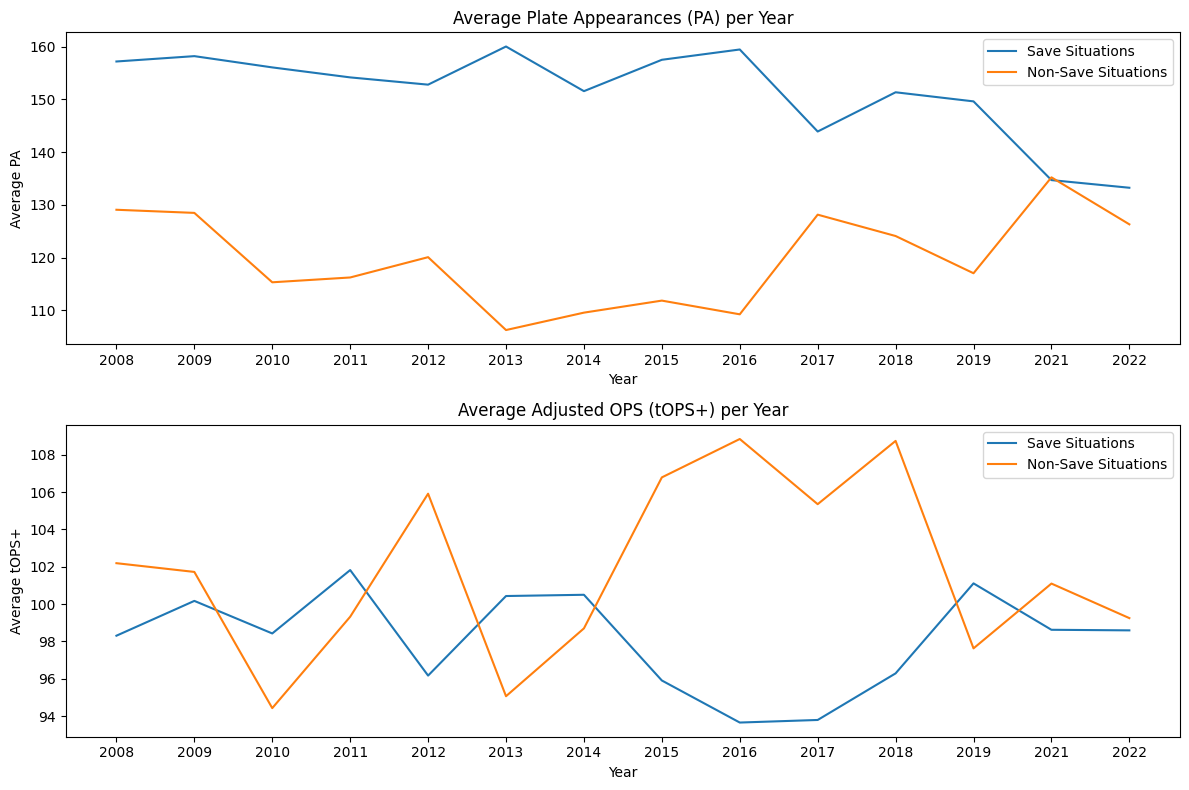

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(grouped_save.index, grouped_save['PA'], label='Save Situations')
plt.plot(grouped_non_save.index, grouped_non_save['PA'], label='Non-Save Situations')
plt.title('Average Plate Appearances (PA) per Year')
plt.xlabel('Year')
plt.ylabel('Average PA')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(grouped_save.index, grouped_save['tOPS+'], label='Save Situations')
plt.plot(grouped_non_save.index, grouped_non_save['tOPS+'], label='Non-Save Situations')
plt.title('Average Adjusted OPS (tOPS+) per Year')
plt.xlabel('Year')
plt.ylabel('Average tOPS+')
plt.legend()

plt.tight_layout()
plt.show()


2016 以後，終結者在非救援情況登版的打席數，開始有增加的趨勢。

In [16]:
# Convert the index to string type
grouped_save.index = grouped_save.index.astype(str)
grouped_non_save.index = grouped_non_save.index.astype(str)

# Define periods
period1 = ('2008', '2016')
period2 = ('2017', '2022')

# Average PA for save and nonsave situations in period 1
average_pa_save_period1 = grouped_save.loc[period1[0]:period1[1], 'PA'].mean()
average_pa_nonsave_period1 = grouped_non_save.loc[period1[0]:period1[1], 'PA'].mean()

# Average PA for save and nonsave situations in period 2
average_pa_save_period2 = grouped_save.loc[period2[0]:period2[1], 'PA'].mean()
average_pa_nonsave_period2 = grouped_non_save.loc[period2[0]:period2[1], 'PA'].mean()

# Calculate differences between periods
diff_save = average_pa_save_period2 - average_pa_save_period1
diff_nonsave = average_pa_nonsave_period2 - average_pa_nonsave_period1

# Calculate percentages
percent_diff_save = (diff_save / average_pa_save_period1) * 100
percent_diff_nonsave = (diff_nonsave / average_pa_nonsave_period1) * 100

# Print differences
print(f"終結者於救援情況面對的打席數從 2008 – 2016 到 2017 – 2022 的變化: {percent_diff_save:.2f}%")
print(f"終結者於非救援情況面對的打席數從 2008 – 2016 到 2017 – 2022 的變化: {percent_diff_nonsave:.2f}%")


終結者於救援情況面對的打席數從 2008 – 2016 到 2017 – 2022 的變化: -8.81%
終結者於非救援情況面對的打席數從 2008 – 2016 到 2017 – 2022 的變化: 8.54%


### 說明
1. 2017 – 2022 跟 2008 – 2016 比起來，終結者在救援情況登版的面對的打席數，平均少 8.8%
2. 2017 – 2022 跟 2008 – 2016 比起來，終結者在非救援情況登版的面對的打席數，平均多 8.5%

以上可以說明，終結者越來越常被利用在非傳統救援情況。

In [20]:
column_names = ['OPS', 'BAbip', 'tOPS+', 'BA', 'SLG', 'OBP']

grouped_save = all_save_df.groupby('Year')[column_names].mean()
grouped_non_save = all_non_save_df.groupby('Year')[column_names].mean()


In [27]:

# Define periods
period1 = ('2008', '2016')
period2 = ('2017', '2022')

def calculate_diff(grouped_save, grouped_non_save, column, period1, period2):
    # Average for save and nonsave situations in period 1
    average_save_period1 = grouped_save.loc[period1[0]:period1[1], column].mean()
    average_nonsave_period1 = grouped_non_save.loc[period1[0]:period1[1], column].mean()

    # Average for save and nonsave situations in period 2
    average_save_period2 = grouped_save.loc[period2[0]:period2[1], column].mean()
    average_nonsave_period2 = grouped_non_save.loc[period2[0]:period2[1], column].mean()

    # Calculate differences between periods
    diff_save = average_save_period2 - average_save_period1
    diff_nonsave = average_nonsave_period2 - average_nonsave_period1

    # Calculate percentages
    percent_diff_save = (diff_save / average_save_period1) * 100
    percent_diff_nonsave = (diff_nonsave / average_nonsave_period1) * 100

    # Print differences
    print(f"\n{column}:")
    print(f"終結者於救援情況 {column}從 2008 – 2016 到 2017 – 2022 的變化: {percent_diff_save:.2f}%")
    print(f"終結者於非救援情況 {column}從 2008 – 2016 到 2017 – 2022 的變化: {percent_diff_nonsave:.2f}%")

# Convert the index to string type
grouped_save.index = grouped_save.index.astype(str)
grouped_non_save.index = grouped_non_save.index.astype(str)

for col in column_names:
    calculate_diff(grouped_save, grouped_non_save, col, period1, period2)



OPS:
終結者於救援情況 OPS從 2008 – 2016 到 2017 – 2022 的變化: 0.97%
終結者於非救援情況 OPS從 2008 – 2016 到 2017 – 2022 的變化: 1.80%

BAbip:
終結者於救援情況 BAbip從 2008 – 2016 到 2017 – 2022 的變化: 0.58%
終結者於非救援情況 BAbip從 2008 – 2016 到 2017 – 2022 的變化: -3.42%

tOPS+:
終結者於救援情況 tOPS+從 2008 – 2016 到 2017 – 2022 的變化: -0.71%
終結者於非救援情況 tOPS+從 2008 – 2016 到 2017 – 2022 的變化: 0.96%

BA:
終結者於救援情況 BA從 2008 – 2016 到 2017 – 2022 的變化: -3.01%
終結者於非救援情況 BA從 2008 – 2016 到 2017 – 2022 的變化: -5.23%

SLG:
終結者於救援情況 SLG從 2008 – 2016 到 2017 – 2022 的變化: 1.83%
終結者於非救援情況 SLG從 2008 – 2016 到 2017 – 2022 的變化: 4.64%

OBP:
終結者於救援情況 OBP從 2008 – 2016 到 2017 – 2022 的變化: -0.06%
終結者於非救援情況 OBP從 2008 – 2016 到 2017 – 2022 的變化: -1.40%


以上前後期的比較很有意思：
1. tOPS+: 終結者在救援情況，壓制力比過往的好一點（差 0.7%），在非救援情況，弱化了大概 1%。但此二筆數據，筆者認為不能解釋什麼。
2. BAbip 在救援情況，比過往來的高 0.6%，然而`在非救援情況，卻比過往低了 3.4%`。
3. 被上壘率以及被打擊率，在救援情況變佳，然而在`非救援情況卻顯得更出色`。
4. 被長打率在兩個情況都較過往來的高，或許這跟全聯盟的趨勢有關，待驗證。

### 結論

1. 終結者在 2017 年以後，有在非救援情況增加出賽的趨勢，並且有減少於救援情況使用的比率。
2. 從 BAbip, BA, OBP 來看，非救援情況的終結者的表現在 2017 年以後，有比過往來得好的趨勢。筆者認為，這似乎可以說明終結者體認到自己的價值已與過往不同的典範轉移。
